# Analysis Notebook

In [370]:
import pandas as pd
import os
import operator

os.chdir("/Users/bencampbell/code_louisville/capstone/louisville-bike-accidents/")

DATA = "data/clean/bike_accidents.csv"
assert os.path.exists(DATA)

df = pd.read_csv(DATA)
#df

In [371]:
df.columns

Index(['investigating_agency', 'roadway_number', 'building_number',
       'roadway_name', 'roadway_suffix', 'roadway_direction', 'milepoint',
       'intersection_roadway_number', 'intersection_roadway_name',
       'between_street_number_1', 'between_street_name_1',
       'between_street_number_2', 'between_street_name_2', 'units_involved',
       'motor_vehicles_involved', 'weather', 'roadway_condition',
       'hit_and_run_indicator', 'roadway_type', 'directional_analysis',
       'manner_of_collision', 'roadway_character', 'light_condition',
       'secondary_collision_indicator', 'date', 'latitude', 'longitude',
       'injury_indicator', 'fatality_indicator', 'day_of_week'],
      dtype='object')

## Questions

Do most accidents occur in intersections?

Do more or less accidents occur at *lighted* intersections?

Which roads are the most dangerous?
Are some parts of the road more dangerous than others. For example, is Bardstown Rd. more or less dangerous in the Highlands vs. further south? Shelbyville road near the Malls?

What type of road is the most dangerous?

Which areas of town are the most dangerous to ride?

What time of day do accidents occur?

What day of the week do the most/least accidents occur?

What are the safest road condiditons to ride? 
Road conditions/weather/light/diretional analysis/manner of collision useful here. 

What's up with "secondary_collision"? Are these more dangerous and/or do they occur very often?

How do accident patterns change over the years? Are there more or less accidents now vs. 2010?

Hit and runs seem to involve a lot of fatalities. Are these types of accidents actually more dangerous?

Are accidents with more vehicles involved more deadly?

In [372]:
# Add some useful columns

# split up time
dates = df['date'] = df['date'].apply(pd.Timestamp)
timesplit = dates.transform({name:operator.attrgetter(name) for name in "year month day hour minute".split()})
df = df.join(timesplit)


In [373]:

# split up roadway charater
#df['roadway_character'].value_counts()
df['roadway_path'] = df['roadway_character'].str.split().apply(lambda x:(x[0]))
df['roadway_elevation'] = df['roadway_character'].str.split().apply(lambda x:x[2])
#df['roadway_character_elevation']
df.columns

# More cleaning type fixes
#df['roadway_condition'].replace(to_replace='WATER (STANDING OR MOVING)',value='WATER', inplace=True)

Index(['investigating_agency', 'roadway_number', 'building_number',
       'roadway_name', 'roadway_suffix', 'roadway_direction', 'milepoint',
       'intersection_roadway_number', 'intersection_roadway_name',
       'between_street_number_1', 'between_street_name_1',
       'between_street_number_2', 'between_street_name_2', 'units_involved',
       'motor_vehicles_involved', 'weather', 'roadway_condition',
       'hit_and_run_indicator', 'roadway_type', 'directional_analysis',
       'manner_of_collision', 'roadway_character', 'light_condition',
       'secondary_collision_indicator', 'date', 'latitude', 'longitude',
       'injury_indicator', 'fatality_indicator', 'day_of_week', 'year',
       'month', 'day', 'hour', 'minute', 'roadway_path', 'roadway_elevation'],
      dtype='object')

In [414]:
# All accidents fatality / injury / neither
Percent = "{:.1%}".format
df['casualty'] = df['fatality_indicator'] | df['injury_indicator']
df['noncasualty'] = ~df['casualty']
dangermask = ['fatality_indicator', 'injury_indicator', 'casualty', 'noncasualty' ]
sums = df.groupby('roadway_condition')[dangermask].sum()
percents = (sums/len(df))
percents.apply(lambda x:round(x*100,2))

totals = sums.apply('sum', axis=1)
percents_by = sums.copy()
for col in percents_by.columns:
    percents_by[col] /= totals
    percents_by[col] = percents_by[col].apply(Percent)
percents_by

,fatality_indicator,injury_indicator,casualty,noncasualty
roadway_condition,,,,
DRY,1.3%,40.4%,41.7%,16.5%
ICE,0.0%,50.0%,50.0%,0.0%
SNOW/SLUSH,0.0%,42.9%,42.9%,14.3%
WATER (STANDING OR MOVING),0.0%,0.0%,0.0%,100.0%
WET,2.6%,41.6%,44.2%,11.6%


In [504]:
road_cond = sums.copy()
road_cond.loc['WET'] = road_cond.loc['ICE':].apply('sum', axis=0)
road_cond = road_cond.loc[['DRY','WET']]
totals = road_cond['casualty'] + road_cond['noncasualty']
cond_percents = road_cond.apply(lambda x:(x/totals).apply(lambda x:round(x*100,2)))
(road_cond['fatality_indicator']/road_cond['casualty']).apply(lambda x:round(x*100,2))

roadway_condition
DRY    3.21
WET    5.68
dtype: float64

In [362]:
# HIT AND RUN
Percent = "{:.1%}".format


HR = pd.DataFrame(df.groupby('hit_and_run_indicator')[['fatality_indicator', 'injury_indicator']].sum())
totals = df['hit_and_run_indicator'].value_counts()
HR['noncasualty'] = totals - HR['fatality_indicator'] - HR['injury_indicator']
HR['total'] = totals

percents = HR.copy()
for name in "fatality_indicator	injury_indicator	noncasualty".split():
    percents[name] /= percents['total']
    percents[name] = percents[name].apply(Percent)
percents['total'] /= percents.total.sum()
percents['total'] = percents['total'].apply(Percent)
percents

,fatality_indicator,injury_indicator,noncasualty,total
hit_and_run_indicator,,,,
False,2.0%,70.6%,27.4%,83.3%
True,4.8%,65.7%,29.6%,16.7%


In [290]:
## INDICATOR MATRIX
# noninjury, total column, intersection betweeen others

indicator_mask = ['injury_indicator', 'fatality_indicator', 'hit_and_run_indicator', 
                  'secondary_collision_indicator']
new = ['injury', 'fatality', 'hit_and_run', 'secondary_collision']

indicators = pd.DataFrame(df[indicator_mask])
indicators = indicators.rename(dict(zip(indicator_mask, new)), axis=1)


<Axes: >

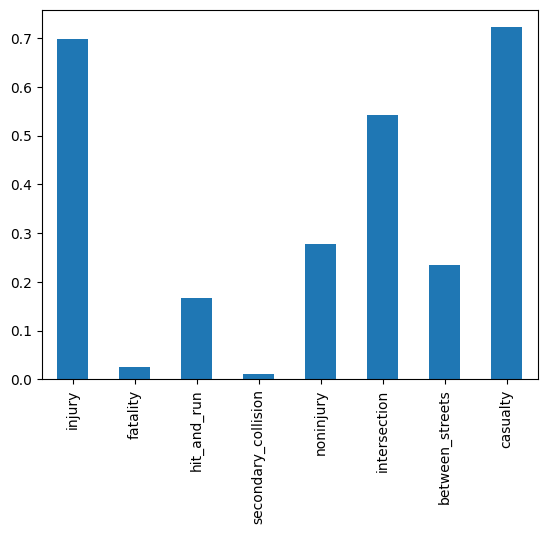

In [309]:

indicators['noninjury'] = ~(indicators['injury'] | indicators['fatality'])
indicators['casualty'] = indicators['injury'] | indicators['fatality']


indicators['intersection'] = (df['intersection_roadway_name'].notnull() | df['intersection_roadway_number'].notnull())

indicators['between_streets'] = (
    df['between_street_name_1'].notnull() | df['between_street_name_2'].notnull() | 
    df['between_street_number_1'].notnull() | df['between_street_number_2'].notnull())

(indicators.sum()/len(indicators)).plot.bar()
#indicators.sum()

In [287]:
pct = lambda x:round(x*100, 2)

hr = indicators.groupby('hit_and_run')
hs = hr.sum()
pc = hs.copy()
totals = pc['total']
for col in pc.columns:
    pc[col] = pct(pc[col]/totals)
del pc['total']
pc


#(hitrsums['injury'] / hitrsums['total']).apply(pct)

,injury,fatality,secondary_collision,noninjury,intersection,between_streets
hit_and_run,,,,,,
False,70.63,2.01,1.14,27.45,55.51,23.60
True,65.65,4.78,0.87,29.57,48.26,22.17


In [ ]:
indicators

In [6]:
import operator

Percent=pct= lambda x:round(x*100, 2)
DF_TOTAL = len(df)
# bring in lighted intersections
#SIG = "/Users/bencampbell/code_louisville/capstone/louisville-bike-accidents/data/preclean/signalized_intersections.csv"
#pd.read_csv(SIG)

In [7]:
df['roadway_condition'].value_counts()

roadway_condition
DRY                           1261
WET                            106
SNOW/SLUSH                       4
WATER (STANDING OR MOVING)       2
ICE                              1
Name: count, dtype: int64

In [8]:
# Most dangerous roads?

#top_most_dangerous_roads = 
# Group by road type?
# Find percents by this: what percent of accidents occur in these most dangerous roads.
#top_most_dangerous_roads.plot(kind='bar', ylabel='value count')



In [632]:

def simple_roadway_id(df:pd.DataFrame):
    df['roadway_id'] = df['roadway_name'].combine_first(df['roadway_number'])

#df.groupby(by='raodway id').size().sort_values(ascending=False)

nn = df.groupby(['roadway_name'])['roadway_number'].nunique()
many_numbered_roadways = nn[nn.values > 1]
# These are all the roads with more than one radway number
many_numbered_roadways

roadway_name
22ND            2
2ND             2
3RD             3
7TH             2
7TH STREET      2
BARDSTOWN       3
BAXTER          2
CANE RUN        2
DIXIE           2
DR W J HODGE    2
LEXINGTON       2
MAIN            3
MANSLICK        3
MARKET          2
SOUTHSIDE       2
TAYLOR          2
TAYLORSVILLE    2
Name: roadway_number, dtype: int64

In [682]:
df[df['roadway_name'].isin(many_numbered_roadways.index)]\
        .groupby('roadway_name')['roadway_number'].unique()

nnu = df.groupby(['roadway_number'])['roadway_name'].nunique()
nnu[nnu.values > 1]

RNMX = pd.DataFrame(df.roadway_number.dropna())
RNMX['KY'] = RNMX['roadway_number'].str.startswith("KY")
RNMX['US'] = RNMX.roadway_number.str.startswith("US")
RNMX['I'] = RNMX.roadway_number.str.startswith("I")

RNMX.I.sum()

11

In [10]:
road_names = df['roadway_name'].dropna().unique()
road_numbers = df['roadway_number'].dropna().unique()


df[df['roadway_name'].isna()] # Numbered roads with no name. Not too many.
# Make a new column 'roadway' for easier analyses.
def test(name, number):
    if pd.notnull(name):
        return name
    else:
        return number

df['roadway'] = df['roadway_name'].combine(df['roadway_number'], test)

# Time of Day

<Axes: xlabel='hour of day', ylabel='accident count'>

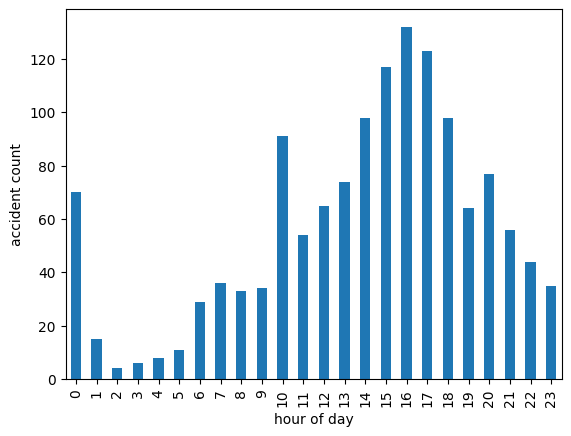

In [11]:
# Time of day
df.groupby('hour').size().plot(kind='bar', xlabel='hour of day', ylabel="accident count")


The graph above is a simple plot of the data, without any manipulation. I think there are outlier values for hour 0 (midnight). I suspect that the way accidents are reported and entered into this database, if a value for time is missing in the report, the time is entered as 00:00:00. In the next code cell I have some further evidence for this.

<Axes: xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT'>

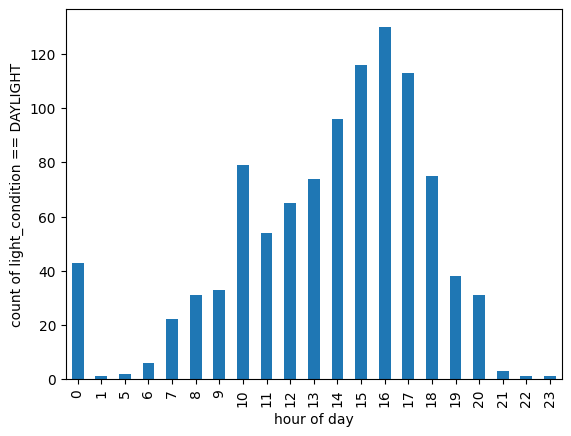

In [12]:
hour_light = df[['hour', 'light_condition']]
hour_light[hour_light['light_condition'] == "DAYLIGHT"].groupby('hour').size().plot(
    kind='bar', xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT')

Definitely an unusual distribution. I would expect the light_condition value to be DAYLIGHT only during normal daylight hours. There are some other outliers to address. Louisville is well below the Arctic Circle, so 1 AM is dark all year, for example. 

In any case, a significant number of records with hour near or equal to 0 report daylight light conditions. I'll exclude my data from my analysis of the time here. 

Now I'll take a look at records where the time has a zero value to see what data I can ignore.

In [13]:
zeros = df[(df.hour==0) & (df.minute==0)]
# Get all rows that have 00:00 time value

#zeros[zeros['date'].apply(lambda x:x.second==0)]
# Check that the seconds are zero too.

zeros_index = zeros[zeros['light_condition'] == "DAYLIGHT"].index
# For recrods that have 00:00 time, find the ones that have light_condition == DAYLIGHT, 
# then filter these records out of my data:

filtered_light = df[~df.index.isin(zeros_index)]
daylight = filtered_light[filtered_light['light_condition'] == "DAYLIGHT"]

daylight_corrections = daylight[daylight['hour'].isin([0,1,22,23])].index
# removing some more outlier values.
# These are records at midnight, 1AM, 10PM, and 11PM where light_condition == DAYLIGHT
# It is conceivable that at the height of Summer someone could report light condition as "daylight" in this location,
# but I'm going to ignore it anyway. If I wanted to be thorough, I'd check the time of year. If this report isn't 
# from Summer, it's definitely not correct. 

daylight = daylight[~daylight.index.isin(daylight_corrections)]

<Axes: xlabel='hour of day', ylabel='DAYLIGHT'>

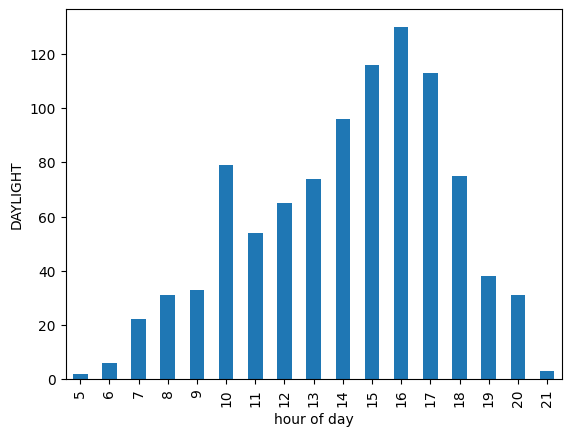

In [14]:
# Now let's see what the time distribution for DAYLIGHT condition looks like:
daylight.groupby('hour').size().plot(kind='bar', ylabel='DAYLIGHT', xlabel='hour of day')


This is much more in line with what I would expect.

I tried to make the next plot a little more granular. This plot is not pretty or easy to read but it does make some patterns more clear. 


748     2014-05-27 05:54:00-04:00
1043    2016-05-11 05:46:00-04:00
Name: date, dtype: object

46      2010-06-03 21:01:00-04:00
65      2010-07-03 21:00:00-04:00
1067    2016-07-15 21:06:00-04:00
Name: date, dtype: object

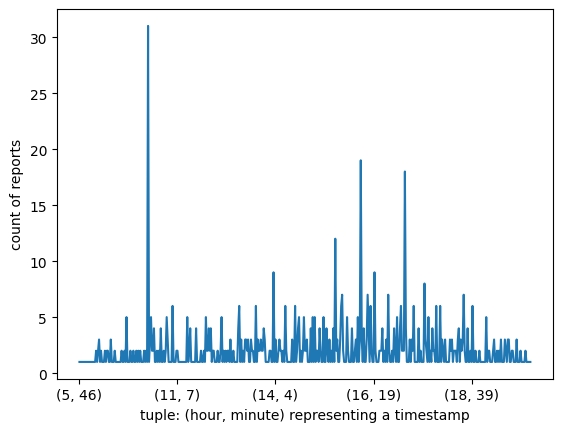

In [15]:
daylight.groupby(['hour', 'minute']).size().plot(xlabel="tuple: (hour, minute) representing a timestamp",
                                                 ylabel='count of reports')
# What's with the huge spike at 10 AM?
# HH:00 seems to be the default way to report the time of accident.

# These seem like reasonable times to see daylight. Future idea: correlate the time of year with average day length for precise day-light cycle information on tap.
display(
    daylight[daylight.hour==5].date, # late 5 o'clock, May
    daylight[daylight.hour==21].date # early 9 o'clock, Summer
)

Unfortunately, there is still a major issue with the data: we do not know how many people are cycling at different times of day. Cyclists tend to avoid riding at night. So, while there are low numbers of accidents at 3 AM, that may only reflect the relatively low number of cyclists riding at that hour, and not the actual danger of that hour to ride as a ratio of riders to accident reports. 

Similarly, we see a very high number of accidents at 3 PM. It may not be the case that 3 PM is an exceptionally dangerous time to ride. There are many cyclists on the road at this time, therefore there are more opportunities for accidents vs. the small number of cyclists who ride at night. 

In [16]:

DAYCOLOR = ['orange', 'red', 'purple']
DARKCOLOR = "orange black purple".split()

times = {
#'all':filtered_light,
'daylight':daylight,
'dawn':filtered_light[filtered_light['light_condition'] == "DAWN"],
'dusk':filtered_light[filtered_light['light_condition'] == "DUSK"],
'lit_hwy':filtered_light[filtered_light['light_condition'] == 'DARK-HWY LIGHTED/ON'],
'unlit_hwy': filtered_light[filtered_light['light_condition'] == 'DARK-HWY LIGHTED/OFF'],
'dark':filtered_light[filtered_light['light_condition'].isin(('DARK (UNKNOWN ROADWAY LIGHTING)', 'OTHER'))]}


In [17]:
mask = ['injury_indicator', 'fatality_indicator', 'noninjury']
new_mask = ['injuries', 'fatalities', 'noninjuries']
TOTAL = len(filtered_light)
pct = lambda x:round(x * 100, 2)
TOTAL_injuries = filtered_light['injury_indicator'].sum()
TOTAL_fatalities = filtered_light['fatality_indicator'].sum()
TOTAL_noninjury = filtered_light['noninjury'].sum()


def make_view(light_condition):
    view = pd.Series(times[light_condition][mask].sum(), name=light_condition).rename(dict(zip(mask, new_mask)))

    total = view.sum()
    view['total'] = total
    view['casualties'] = view.fatalities + view.injuries
    view["%_of_all_accidents"] = pct(total/TOTAL)
    view["%_fatality"] = pct(view.fatalities/total)
    view["%_casualty"] = pct(view.casualties/total)
    view["%_noninjury"] = pct(view.noninjuries/total)
    view['%_fatality_of_all'] = pct(view.fatalities/TOTAL_fatalities)
    view['%_injury_of_all'] = pct(view.injuries/TOTAL_injuries)
    view['%_fatality_of_casualty'] = pct(view.fatalities/view.casualties)
    return view

make_view('dark')

KeyError: 'noninjury'

In [ ]:
summary = pd.DataFrame({key:make_view(key)for key in times}).transpose()
#summary[['%_of_all_accidents','%_casualty','%_fatality']].plot.bar()
summary['%_of_all_accidents'].plot.bar()
summary[['%_noninjury','%_casualty','%_fatality_of_all']].plot.bar()

NameError: name 'make_view' is not defined

In [ ]:
hourly_summary = filtered_light.groupby('hour')[mask]
hourly_summary = hourly_summary.sum().rename(dict(zip(mask, new_mask)), axis=1)
hourly_summary['total'] = hourly_summary.apply("sum", axis=1)
TOTAL = hourly_summary.total.sum()

hourly_summary['%_of_all_accidents'] = pct(hourly_summary.total / TOTAL)
hourly_summary['casualties'] = hourly_summary.fatalities + hourly_summary.injuries
hourly_summary['%_noninjury'] = pct(hourly_summary.noninjuries/hourly_summary.total)
hourly_summary['%_casualty'] = pct(hourly_summary.casualties / hourly_summary.total)
hourly_summary['%_fatality'] = pct(hourly_summary.fatalities/hourly_summary.total)
hourly_summary['%_fatality_of_casualty'] = pct(hourly_summary.fatalities/hourly_summary.casualties)
hourly_summary['%_injury_of_casualty'] = pct(hourly_summary.injuries/hourly_summary.casualties)

hourly_summary[["%_of_all_accidents"]].plot.bar()
hourly_summary[['%_casualty', '%_fatality_of_casualty']].plot.bar()

KeyError: "Columns not found: 'noninjury'"

From these graphs, it's pretty clear to see that cycling in the dark is much less safe than cycling in the day, even though more accidents occur in the day. 



## Road conditions

In [ ]:
out = df.groupby(['roadway_condition', 'weather', 'light_condition'])[['injury_indicator', 'fatality_indicator']].sum()
#
#df['roadway_condition'].replace(to_replace='WATER (STANDING OR MOVING)',value='WATER', inplace=True)
condition_codes = pd.DataFrame(df['roadway_condition'].unique())
condition_codes['total'] = condition_codes[0].apply(lambda n:out.loc[n].sum().sum())

out.groupby(by='roadway_condition').sum()

,injury_indicator,fatality_indicator
roadway_condition,,
DRY,876,29
ICE,1,0
SNOW/SLUSH,3,0
WATER (STANDING OR MOVING),0,0
WET,79,5


In [ ]:
# INJURIES FATALITIES
mask  =['injury_indicator', 'fatality_indicator', 'noninjury']
noninjury = df[df['noninjury'] == False]
RWC = df.groupby('roadway_condition')
FI = RWC[['fatality_indicator']].agg(("sum", 'size'))
FI

HR = df.groupby(['hit_and_run_indicator'])[mask].sum()
#HR['total'] = 
HR['total'] = HR.transpose().sum()
HR['fatality_percent'] = pct(HR.fatality_indicator / HR.total)
HR['injury_percent'] = pct(HR.injury_indicator / HR.total)

HR

# Whats the injury percent for all accidents?
inj = df['injury_indicator'].value_counts()
inj.apply(lambda x:pct(x/len(df))), HR

KeyError: 'noninjury'

In [18]:
units = pd.DataFrame(df[['units_involved', 'motor_vehicles_involved']])
units['nonmotorized_units_involved'] = units['units_involved'] - units['motor_vehicles_involved']

units


,units_involved,motor_vehicles_involved,nonmotorized_units_involved
0,2,1,1
1,2,1,1
2,2,1,1
3,2,1,1
4,2,1,1
...,...,...,...
1369,3,2,1
1370,2,1,1
1371,2,1,1
1372,2,1,1


<Axes: xlabel='year'>

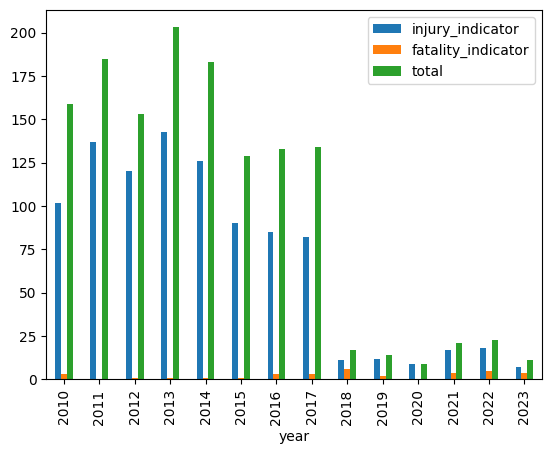

In [140]:
# YEAR
years = df.groupby('year')[['injury_indicator', 'fatality_indicator']].sum()
years['total'] = df.groupby('year')['year'].size()

years.plot.bar()


<Axes: xlabel='month'>

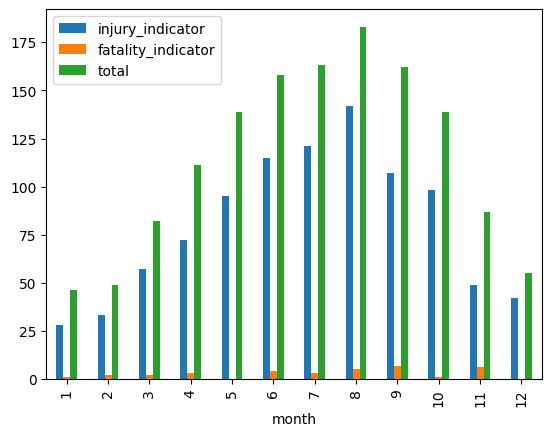

In [158]:

# month
months = df.groupby('month')[['injury_indicator', 'fatality_indicator']].sum()
months['total'] = df.groupby('month')['month'].size()

months.plot.bar()

<Axes: xlabel='month'>

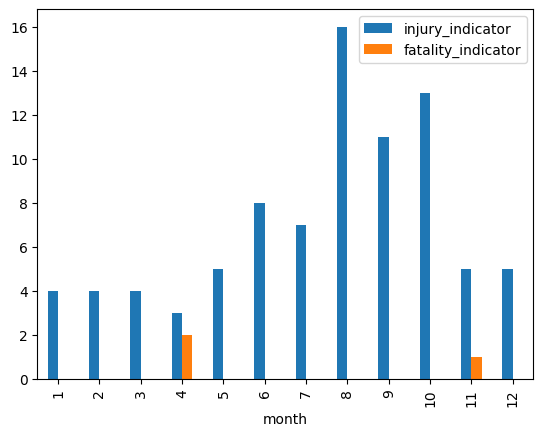

In [187]:
#month_year
MY = df.groupby(['year', 'month'])[['injury_indicator', 'fatality_indicator']].sum()
#MY.groupby('month').sum().plot.bar()
MY.loc[2016].plot.bar()

manner_of_collision
SINGLE VEHICLE                  1273
ANGLE                             67
SIDESWIPE-SAME DIRECTION          14
REAR END                          10
HEAD ON                            6
OPPOSING LEFT TURN                 3
SIDESWIPE-OPPOSITE DIRECTION       1
Name: count, dtype: int64

<Axes: xlabel='manner_of_collision'>

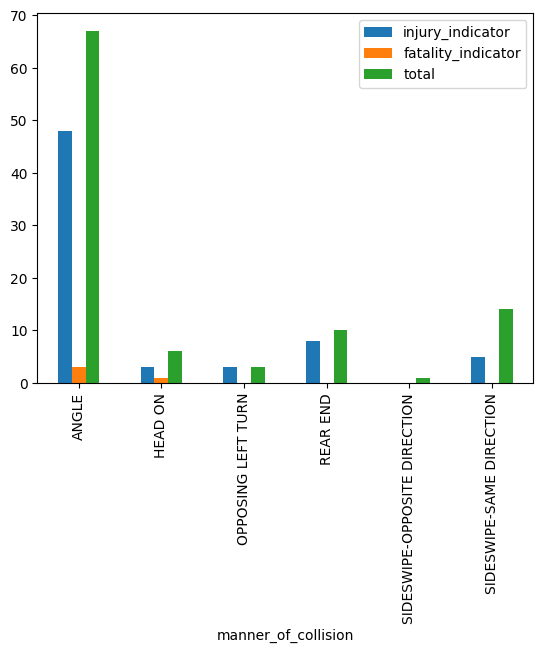

In [189]:
def get_totals_by(by):
    out = df.groupby(by)[['injury_indicator', 'fatality_indicator']].sum()
    out['total'] = df.groupby(by)[by].size()

    #out.plot.bar()
    return out
#print(df.columns)

MOC = df['manner_of_collision']
display(MOC.value_counts())


# Plot not SINGLE VEHICLE
get_totals_by("manner_of_collision").iloc[:-1].plot.bar()

In [117]:
geo = df[df['roadway_name'] == "DIXIE"][['longitude', 'latitude']]

import numpy as np
from math import sqrt


def point(longitude, latitude):
    return np.array((longitude, latitude))

def distance(point_a, point_b):
    long_a, lat_a = point_a
    long_b, lat_b = point_b
    dist_long = long_a - long_b
    dist_lat = lat_a - lat_b
    return sqrt(dist_long**2 + dist_lat**2)

points = pd.DataFrame(geo.longitude.combine(geo.latitude, point))

points


,0
37,"[-85.8047443, 38.1970461]"
56,"[-85.7915663, 38.2259046]"
86,"[-85.8040117, 38.1977195]"
125,"[-85.8266313, 38.1709652]"
135,"[-85.8067399, 38.1941699]"
...,...
1315,"[-85.79113155, 38.22668024]"
1325,"[-85.8399874, 38.14291255]"
1326,"[-85.8399874, 38.14291255]"
1347,"[-85.87415593, 38.09328054]"


In [190]:

for index in points.index:
    comp = points[0][index]
    points[index] = points[0].apply(lambda x:distance(comp, x))

threshold = .05
out = list()
for i in points.index:
    for j in points.index:
        if points[j][i] <= threshold:
            out.append((i,j))
out, len(out)



([(37, 37),
  (37, 56),
  (37, 86),
  (37, 125),
  (37, 135),
  (37, 190),
  (37, 208),
  (37, 285),
  (37, 363),
  (37, 365),
  (37, 367),
  (37, 392),
  (37, 434),
  (37, 441),
  (37, 510),
  (37, 580),
  (37, 600),
  (37, 639),
  (37, 746),
  (37, 805),
  (37, 814),
  (37, 822),
  (37, 832),
  (37, 836),
  (37, 840),
  (37, 916),
  (37, 976),
  (37, 1042),
  (37, 1048),
  (37, 1049),
  (37, 1075),
  (37, 1082),
  (37, 1099),
  (37, 1112),
  (37, 1129),
  (37, 1187),
  (37, 1247),
  (37, 1315),
  (56, 37),
  (56, 56),
  (56, 86),
  (56, 135),
  (56, 190),
  (56, 208),
  (56, 285),
  (56, 363),
  (56, 365),
  (56, 367),
  (56, 392),
  (56, 434),
  (56, 444),
  (56, 580),
  (56, 600),
  (56, 639),
  (56, 746),
  (56, 805),
  (56, 814),
  (56, 822),
  (56, 836),
  (56, 840),
  (56, 916),
  (56, 999),
  (56, 1042),
  (56, 1048),
  (56, 1082),
  (56, 1099),
  (56, 1129),
  (56, 1187),
  (56, 1247),
  (56, 1315),
  (86, 37),
  (86, 56),
  (86, 86),
  (86, 125),
  (86, 135),
  (86, 190),
  